In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

ratings = pd.read_csv('/content/drive/MyDrive/ratings.csv', sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

movies = pd.read_csv('/content/drive/MyDrive/movies.csv', sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

In [3]:
movies.head(5)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354


### Content Based

**Objective**: Build a Content-Based Recommendation system that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre.

**Dataset**:
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Split the `genres` column into separate genre strings.
   - Fill any missing values in the `genres` column and convert it to string.

2. **Compute TF-IDF Matrix**:
   - Use `TfidfVectorizer` to transform the genres into a TF-IDF matrix.

3. **Calculate Cosine Similarity**:
   - Compute cosine similarity between the TF-IDF matrices of movies.

4. **Recommend Movies**:
   - Create a function that gets movie recommendations based on the cosine similarity score of movie genres.

In [5]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna("").astype('str')

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])

In [7]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [8]:
def genre_recommendations(title, n=10):

    movie_index= movies.index[movies['title']==title].tolist()[0]
    similarity_scores= sorted(list(enumerate(cosine_sim[movie_index])), key= lambda x: x[1], reverse= True)[1:n+1]

    return movies.iloc[[i[0] for i in similarity_scores]][['title']]


In [9]:
# Example
genre_recommendations('GoldenEye (1995)')

,title
345,Clear and Present Danger (1994)
543,Surviving the Game (1994)
724,"Rock, The (1996)"
788,Daylight (1996)
825,Chain Reaction (1996)
978,Maximum Risk (1996)
1467,Anaconda (1997)
1513,Con Air (1997)
1693,Firestorm (1998)
3686,"Perfect Storm, The (2000)"



### Collaborative Filtering

**Objective**: Implement a collaborative filtering movie recommendation system to recommend movies to a user based on similar users' spreferences.

**Dataset**:

- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Split `genres` column into separate rows.

2. **Create User-Genre Matrix**:
   - Create a matrix where rows are users and columns are genres.
   - Each cell represents the ratio of movies watched by the user in that genre to the total movies watched by the user.

3. **Calculate User Similarity**:
   - Use cosine similarity to calculate the similarity between users.

4. **Find Top N Similar Users**:
   - Find the top N users with the most similar preferences to the given user.

5. **Recommend Movies**:
   - Recommend movies that similar users have watched but the target user has not.
   - Return titles and genres of the top 10 recommended movies.

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
import pandas as pd

ratings = pd.read_csv('/content/drive/MyDrive/ratings.csv', sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

movies = pd.read_csv('/content/drive/MyDrive/movies.csv', sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

In [12]:
data = pd.merge(ratings, movies, on='movie_id')

In [13]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),Drama


In [14]:
data = data.assign(genres=data['genres'].str.split('|')).explode('genres')

In [15]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),Drama


In [16]:
user_genre_matrix= data.pivot_table(index= 'user_id', columns= 'genres', aggfunc= 'size', fill_value= 0)
for index, row in user_genre_matrix.iterrows():
    row_sum= row.sum()
    user_genre_matrix.loc[index]/= row_sum

In [17]:
user_similarity= cosine_similarity(user_genre_matrix)

def get_top_n_similar_users(user_id, n):
    return  [i+1 for i in np.argsort(user_similarity[user_id-1])[::-1][1:n+1]]


In [18]:
def recommend_movies(user_id, n_similar_users=5, n_recommendations=10):
    similar_users= get_top_n_similar_users(user_id, n_similar_users)
    similar_users_movies= data[data['user_id'].isin(similar_users)]
    target_user_movies= list((data[data['user_id']==user_id])['movie_id'].unique())

    res_movies= []
    count= 0
    for movie in similar_users_movies['movie_id'].value_counts().index:
        if movie not in target_user_movies:
          res_movies.append(movie)
          count+= 1
        if count==n_recommendations:
            break

    return (movies[movies['movie_id'].isin(res_movies)])[['title', 'genres' ]]

In [19]:
# Example
user_id = 1
recommended_movies = recommend_movies(user_id, n_similar_users=5, n_recommendations=10)

In [20]:
recommended_movies

,title,genres
33,Babe (1995),Children's|Comedy|Drama
900,Casablanca (1942),Drama|Romance|War
1019,Alice in Wonderland (1951),Animation|Children's|Musical
1262,Fantasia (1940),Animation|Children's|Musical
1575,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
2009,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical
2011,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance
2012,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance
2018,Peter Pan (1953),Animation|Children's|Fantasy|Musical
2027,Sleeping Beauty (1959),Animation|Children's|Musical


### SVD (Singular Value Decomposition)



**Objective**: Implement an SVD-based recommendation system to recommend movies to users by decomposing the user-item interaction matrix into latent factors.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Create a user-item matrix where rows represent users, columns represent movies, and the values are the ratings.

2. **Decompose Matrix using SVD**:
   - Apply Singular Value Decomposition (SVD) to decompose the user-item matrix into three matrices: $U$, $\Sigma$, and $V^T$.

3. **Reconstruct Matrix**:
   - Reconstruct the user-item matrix using the top $k$ singular values to reduce dimensionality.

4. **Predict Ratings**:
   - Use the reconstructed matrix to predict ratings for all user-item pairs.

5. **Recommend Movies**:
   - Recommend the top 20 movies with the highest predicted ratings for a given user that the user hasn't rated yet.

In [21]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


Fill na elements.

In [22]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# calculate rating matrix

In [24]:
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(np.array(Ratings), k= 700)
sigma = np.diag(sigma)

In [25]:
all_user_predicted_ratings= np.dot(np.dot(U, sigma), Vt)


In [26]:
preds= pd.DataFrame(all_user_predicted_ratings, columns= Ratings.columns)
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.880510,0.115819,0.028142,0.257570,-0.015679,-0.183566,0.106472,-0.141028,0.047288,-0.130204,...,0.059131,-0.043600,0.037255,-0.050048,0.015885,-0.015608,-0.249205,-0.066936,0.034300,-0.039068
1,0.073121,0.062988,0.182938,0.010992,0.259662,-0.064819,0.000267,0.010744,0.129163,0.354578,...,-0.019596,0.016695,-0.057406,0.066163,0.093729,-0.178427,-0.214989,-0.013916,-0.024880,0.039195
2,0.276953,0.039163,-0.023616,0.072397,0.046910,0.003788,0.283869,-0.110921,0.019192,0.475016,...,0.140873,0.004808,0.067240,-0.043396,0.008602,0.082269,0.041978,0.045288,0.056591,-0.343274
3,0.028093,0.183133,0.042777,-0.056041,0.226957,0.024376,0.041433,-0.018248,0.002057,0.011187,...,-0.049163,0.041476,0.029465,-0.069905,-0.006527,-0.024830,0.104971,0.068225,-0.033384,-0.337280
4,-0.140386,-0.920369,-0.422698,0.070910,0.135977,1.838198,0.503429,0.092210,-0.111263,0.135799,...,0.087990,0.045339,-0.122165,-0.072915,-0.156265,0.087963,0.002134,0.008369,-0.217577,-0.401456


In [27]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):

    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions= predictions.iloc[user_row_number].sort_values(ascending=False)

    # merfe movies data with user_data
    user_data= original_ratings[original_ratings.user_id==userID]
    user_full= (user_data.merge(movies, how='left', left_on='movie_id', right_on='movie_id').sort_values(['rating'], ascending=False))

    print(f'User {userID} has already rated {user_full.shape[0]} movies.')
    print(f'Recommending highest {num_recommendations} predicted ratings movies not already rated.')

    not_seen_movies= []
    for movie in user_full['movie_id']:
        if movie not in not_seen_movies:
          not_seen_movies.append(movie)
    not_seen_movies= movies[movies['movie_id'].isin(not_seen_movies)].merge(pd.DataFrame(sorted_user_predictions).reset_index(), how='left',left_on='movie_id', right_on='movie_id')

    recommendations= not_seen_movies.sort_values(user_row_number, ascending= False).iloc[:num_recommendations, :-1]

    return user_full, recommendations

In [28]:
already_rated, predictions = recommend_movies(preds, 4375, movies, ratings, 20)

User 4375 has already rated 325 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [29]:
ratings.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
5,1,1197,3,0,1196
6,1,1287,5,0,1286
7,1,2804,5,0,2803
8,1,594,4,0,593
9,1,919,4,0,918


In [30]:
# Top 20 movies that User 4375 has rated
already_rated.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
195,4375,3250,5,4374,3249,Alive (1993),Drama
285,4375,175,5,4374,174,Kids (1995),Drama
199,4375,3257,5,4374,3256,"Bodyguard, The (1992)",Action|Drama|Romance|Thriller
65,4375,3809,5,4374,3808,What About Bob? (1991),Comedy
210,4375,2688,5,4374,2687,"General's Daughter, The (1999)",Drama|Thriller
270,4375,150,5,4374,149,Apollo 13 (1995),Drama
271,4375,2710,5,4374,2709,"Blair Witch Project, The (1999)",Horror
125,4375,349,5,4374,348,Clear and Present Danger (1994),Action|Adventure|Thriller
60,4375,288,5,4374,287,Natural Born Killers (1994),Action|Thriller
141,4375,47,5,4374,46,Seven (Se7en) (1995),Crime|Thriller


#### Evaluation

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

train_ratings= train_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
R_train= train_ratings.values
user_ratings_mean_train= np.mean(R_train, axis=1)
Ratings_demeaned_train= R_train-user_ratings_mean_train.reshape(-1, 1)

U_train, sigma_train, Vt_train= svds(Ratings_demeaned_train, k=700)
sigma_train = np.diag(sigma_train)

all_user_predicted_ratings_train= np.dot(np.dot(U_train, sigma_train), Vt_train)+user_ratings_mean_train.reshape(-1, 1)
preds_train= pd.DataFrame(all_user_predicted_ratings_train, columns=train_ratings.columns)

def predict_rating(user_id, movie_id):
    if (user_id-1) in preds_train.index and movie_id in preds_train.columns:
        return preds_train.loc[user_id-1, movie_id]
    else:
        return np.nan

test_data['predicted_rating'] = test_data.apply(lambda x: predict_rating(x['user_id'], x['movie_id']), axis=1)

test_data.dropna(inplace=True)

rmse = sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 3.595961335888939


### Nueral Network Model (Recommender Model)



**Objective**: Implement a Recommender model to recommend movies to a user based on similar users' preferences.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Define Dataset and DataLoader**:
   - Create a custom PyTorch `Dataset` for ratings.
   - Create a DataLoader for batching and shuffling data.

2. **Define the Neural Network**:
   - Create a neural network with embedding layers for users and movies.

3. **Train the Model**:
   - Train the model using Mean Squared Error loss and Adam optimizer.
   - Save model checkpoints.

4. **Evaluate the Model**:
   - Calculate RMSE on the entire dataset.

5. **Predict Ratings for Unrated Movies**:
   - Predict and recommend top 10 unrated movies for a given user.

In [35]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

from sklearn.metrics import mean_squared_error
from math import sqrt

In [46]:
ratings = pd.read_csv('/content/drive/MyDrive/ratings.csv', sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])
movies = pd.read_csv('/content/drive/MyDrive/movies.csv', sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

In [40]:
# Define the dataset
class RatingsDataset(Dataset):
    def __init__(self, ratings):
        self.users= ratings['user_id'].values
        self.movies= ratings['movie_id'].values
        self.ratings= ratings['rating'].values

    def __len__(self):
         return len(self.ratings)

    def __getitem__(self, idx):
        return torch.tensor(self.users[idx], dtype=torch.long), torch.tensor(self.movies[idx], dtype=torch.long), torch.tensor(self.ratings[idx], dtype=torch.float)

# Define the neural network
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size= 50):
        super(RecommenderNet, self).__init__()
        self.user_embedding= nn.Embedding(num_users, embedding_size)
        self.movie_embedding= nn.Embedding(num_movies, embedding_size)
        self.l1= nn.Linear(embedding_size*2, 128)
        self.l2= nn.Linear(128, 1)
        self.relu= nn.ReLU()

    def forward(self, user, movie):
        u_e= self.user_embedding(user)
        m_e= self.movie_embedding(movie)
        x= torch.cat([u_e, m_e], dim=1)
        x= self.l1(x)
        x= self.relu(x)
        x= self.l2(x)
        return x

# Create the dataset and dataloader
data= RatingsDataset(ratings)
dataloader= DataLoader(data, batch_size=64, shuffle=True)


# Initialize the model, loss function and optimizer
model= RecommenderNet(ratings['user_id'].nunique()+500, ratings['movie_id'].nunique()+500)
loss_function= nn.MSELoss()
optimizer= torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs= 10
for epoch in range(num_epochs):
    model.train()
    running_loss= 0.0
    for u, m, r in dataloader:
        optimizer.zero_grad()
        preds= model(u, m).squeeze()
        loss= loss_function(preds, r)
        loss.backward()
        optimizer.step()
        running_loss+= (loss.item()*len(u))

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader.dataset)}')

Epoch 1/10, Loss: 0.9639633618697239
Epoch 2/10, Loss: 0.8430743550029629
Epoch 3/10, Loss: 0.8256028971403044
Epoch 4/10, Loss: 0.8122663291654186
Epoch 5/10, Loss: 0.7990158835517914
Epoch 6/10, Loss: 0.7847886988580431
Epoch 7/10, Loss: 0.7693425616133902
Epoch 8/10, Loss: 0.7541567351942754
Epoch 9/10, Loss: 0.7399984167224827
Epoch 10/10, Loss: 0.7266547322684679


In [44]:
# Evaluation
model.eval()
y_preds= []
y= []
with torch.no_grad():
    for u, m, r in dataloader:
      y_preds.extend(list(model(u, m)))
      y.extend(list(r))

print(f'Root Mean Squared Error: {sqrt(mean_squared_error(y, y_preds))}')


Root Mean Squared Error: 0.8365228332759609


In [47]:
# Example

sample_user_id = 1
sample_user_data = ratings[ratings['user_id'] == sample_user_id]
sample_dataset = RatingsDataset(sample_user_data)
sample_dataloader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

print(f'Sample predictions for user ID {sample_user_id}:')
with torch.no_grad():
    for user, movie, rating in sample_dataloader:
        output = model(user, movie).squeeze()
        print(f'Movie ID: {movie.item()}, Predicted Rating: {output.item()}, Actual Rating: {rating.item()}')

Sample predictions for user ID 1:
Movie ID: 1193, Predicted Rating: 4.6674394607543945, Actual Rating: 5.0
Movie ID: 661, Predicted Rating: 3.764833927154541, Actual Rating: 3.0
Movie ID: 914, Predicted Rating: 3.9181666374206543, Actual Rating: 3.0
Movie ID: 3408, Predicted Rating: 4.060642719268799, Actual Rating: 4.0
Movie ID: 2355, Predicted Rating: 3.9028310775756836, Actual Rating: 5.0
Movie ID: 1197, Predicted Rating: 4.567135334014893, Actual Rating: 3.0
Movie ID: 1287, Predicted Rating: 4.2218170166015625, Actual Rating: 5.0
Movie ID: 2804, Predicted Rating: 4.654700756072998, Actual Rating: 5.0
Movie ID: 594, Predicted Rating: 4.1045002937316895, Actual Rating: 4.0
Movie ID: 919, Predicted Rating: 4.426537036895752, Actual Rating: 4.0
Movie ID: 595, Predicted Rating: 4.080826282501221, Actual Rating: 5.0
Movie ID: 938, Predicted Rating: 3.938628673553467, Actual Rating: 4.0
Movie ID: 2398, Predicted Rating: 4.068169116973877, Actual Rating: 4.0
Movie ID: 2918, Predicted Ratin

In [51]:
def predict_unrated_movies(user_id, model, ratings, movies, n_preds):
    model.eval()

    rated_movies= ratings[ratings['user_id']==user_id]['movie_id'].values
    not_rated_movies= movies[~movies['movie_id'].isin(rated_movies)]
    not_rated_ids= not_rated_movies['movie_id'].values

    with torch.no_grad():
        preds= model(torch.tensor([user_id]*len(not_rated_ids), dtype= torch.long), torch.tensor(not_rated_ids, dtype= torch.long)).squeeze().numpy()

    not_rated_movies['preds']=preds
    return not_rated_movies.sort_values(by='preds', ascending=False).head(n_preds)

# Example
user_id = 1
predictions = predict_unrated_movies(user_id, model, ratings, movies, 10)
print(predictions)

      movie_id                                              title  \
3127      3196                                   Stalag 17 (1953)   
2434      2503                            Apple, The (Sib) (1998)   
740        750  Dr. Strangelove or: How I Learned to Stop Worr...   
1203      1221                     Godfather: Part II, The (1974)   
911        923                                Citizen Kane (1941)   
3176      3245                I Am Cuba (Soy Cuba/Ya Kuba) (1964)   
1210      1228                                 Raging Bull (1980)   
662        668                             Pather Panchali (1955)   
1162      1178                              Paths of Glory (1957)   
2836      2905                                     Sanjuro (1962)   

                  genres     preds  
3127           Drama|War  5.120505  
2434               Drama  5.079516  
740           Sci-Fi|War  4.957000  
1203  Action|Crime|Drama  4.948561  
911                Drama  4.932202  
3176              

<ipython-input-51-d60584a014de>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_rated_movies['preds']=preds


### GMM (Gaussian Mixture Model)

**Objective**: Use a Gaussian Mixture Model to analyze and cluster the click data based on the number of clicks from different locations, aiming to identify distinct patterns of user behavior across 10 countries.

**Dataset**:
- **Click Data**: DataFrame with columns `link_id`, `location`, and `number_of_clicks`.

**Steps**:

1. **Preprocess Data**:
   - Ensure the dataset contains 10 distinct countries.
   - Create a matrix where rows represent different links and columns represent the number of clicks from each country.
   - Normalize the number of clicks to account for different scales.

2. **Fit GMM**:
   - Apply a Gaussian Mixture Model (GMM) to the click data matrix to identify clusters of links with similar click patterns across different countries.

3. **Evaluate Model**:
   - Analyze the resulting model by calculating the log lokelihood, BIC and AIC metrics.


In [66]:
file_path=  '/content/drive/MyDrive/gmm-dataset.csv'
df= pd.read_csv(file_path)
df.head(5)

,URL,United States,China,India,Japan,Brazil,Russia,Indonesia,Germany,United Kingdom,France
0,url_1,657,194,310,790,768,436,189,973,448,335
1,url_2,389,149,354,729,629,937,345,967,764,104
2,url_3,979,475,509,769,270,705,113,931,977,213
3,url_4,524,699,692,694,473,160,484,37,956,899
4,url_5,767,661,319,572,399,401,277,596,631,203


In [76]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

countries= list(df.columns)
assert len(countries)-1==10, "Dataset doesn't contain exactly 10 countries."

clicks= df.drop(columns= ['URL'])

normalized_clicks= StandardScaler().fit_transform(clicks)
n_clusters= 11

gmm= GaussianMixture(n_components= n_clusters, random_state= 42)
gmm.fit(normalized_clicks)

log_likelihood= gmm.score(normalized_clicks)
bic= gmm.bic(normalized_clicks)
aic= gmm.aic(normalized_clicks)

print(f"Log-Likelihood: {log_likelihood}")
print(f"BIC: {bic}")
print(f"AIC: {aic}")


Log-Likelihood: 1.2657007499292598
BIC: 3085.6082348555146
AIC: 1196.859850014148


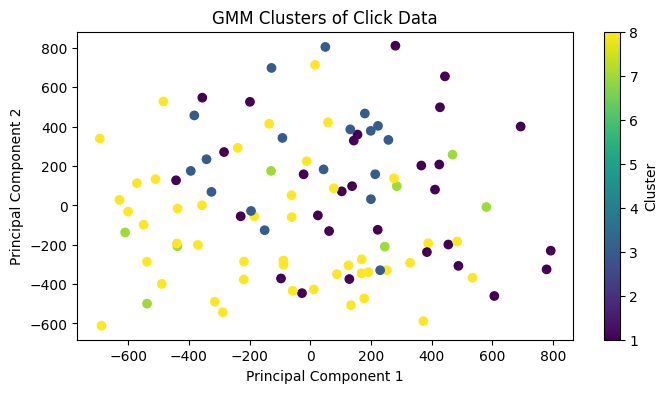

In [80]:
from sklearn.decomposition import PCA

labels= gmm.predict(clicks)

df['Cluster']= labels

pca= PCA(n_components=2)
components= pca.fit_transform(clicks)

plt.figure(figsize=(8, 4))
plt.scatter(components[:, 0], components[:, 1], c= labels, cmap= 'viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('GMM Clusters of Click Data')
plt.colorbar(label='Cluster')
plt.show()